**Mount the drive**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


**Unzip the data**

In [2]:
zip_path = '/content/gdrive/My Drive/Dataset.zip'
!unzip '$zip_path' 
!unzip -q '/content/SIMS dataset/images.zip' 
!unzip -q '/content/SIMS dataset/Annotations_in_3_formats.zip' 

Archive:  /content/gdrive/My Drive/Dataset.zip
  inflating: SIMS dataset/test.txt   
  inflating: SIMS dataset/validation.txt  
  inflating: SIMS dataset/training.txt  
  inflating: SIMS dataset/Assignment-2_modified scope.pdf  
  inflating: SIMS dataset/Annotations_in_3_formats.zip  
  inflating: SIMS dataset/images.zip  


**Copy the Pascal_Voc Annotations to the images folder**

In [0]:
%cp -R "/content/annotations/pascal_voc/Annotations/."  "/content/images"


**Make the directories**

In [0]:
!mkdir Dataset
!mkdir Dataset/train
!mkdir Dataset/train/images
!mkdir Dataset/train/annotations
!mkdir Dataset/valid
!mkdir Dataset/valid/images
!mkdir Dataset/valid/annotations
!mkdir Dataset/test
!mkdir Dataset/test/images
!mkdir Dataset/test/annotations

**Creating CSV files and placing images and labels in the directories**

In [0]:
import shutil
import os
#copy files based on {datasets in txt}

def copy(filepath,dest_dir):
    with open(filepath) as fp:
        for line in fp:
            os.makedirs(dest_dir, exist_ok=True)  # succeeds even if directory exists.
            shutil.copy(line.replace('\n', ''), dest_dir+"/images") #image
            shutil.copy(line.replace('.jpg\n', '.xml'), dest_dir+"/annotations") ##label

#copy files based on {datasets in txt}
copy('/content/SIMS dataset/training.txt','Dataset/train/')
copy('/content/SIMS dataset/validation.txt','Dataset/valid/')
copy('/content/SIMS dataset/test.txt','Dataset/test/')

#from preprocessing.pascal_voc_to_csv import xml_to_csv

import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET

def xml_to_csv(path,image_path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        #print(xml_file)
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            bbx = member.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = member.find('name').text
            
            size = root.find('size') #contains height and width of image
            w = int(size.find('width').text)
            h = int(size.find('height').text)
            
            # truncate any bb coordinates that fall outside of the image
            xmin = max(0, xmin)
            ymin = max(0, ymin)
            xmax = min(w, xmax)
            ymax = min(h, ymax)
            
            # # ignore the bounding boxes where the minimum values are larger
            # # than the maximum values and vice-versa due to annotation errors
            if xmin >= xmax or ymin >= ymax:
                continue
            elif xmax <= xmin or ymax <= ymin:
                continue
            
            file_path = image_path+root.find('filename').text+".jpg"
            value = (file_path,
                     xmin,
                     ymin,
                     xmax,
                     ymax,
                     label,
                     )
            xml_list.append(value)
    column_name = ['filename','xmin', 'ymin', 'xmax', 'ymax','class']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():
    root_path = "Dataset/"
    datasets = ['train','test','valid']
    for ds in datasets:
        #image_path = os.path.join(os.getcwd(), root_path+ds, 'annotations')
        image_path = os.path.join(root_path+ds, 'annotations/')
        print(image_path)
        update_path = os.path.join(root_path+ds, 'images/')
        xml_df = xml_to_csv(image_path,update_path)
        xml_df.to_csv('labels_{}.csv'.format(ds), index=None, header=False)
        print('Successfully converted xml to csv.')

**Clone the Repository**

In [6]:
!git clone https://github.com/fizyr/keras-retinanet 

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 5711 (delta 0), reused 1 (delta 0), pack-reused 5705
Receiving objects: 100% (5711/5711), 13.37 MiB | 15.04 MiB/s, done.
Resolving deltas: 100% (3831/3831), done.


**Run the command for installing the packages**

In [7]:
!pip install ./keras-retinanet/

Processing ./keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=170130 sha256=4565fa9931adaf7a8483458d83264e90df555af9d360be3df695abdeb8165cfc
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.1.0-py2.py3-none-any.whl size=13346 sha256=bfa5556a9c62953f87e012b5ded28a6d3b9eb09cf21caf3b591c68f3b9dc643b
  Stored in directory: /root/.cache/pip/wheels/80/dd/ac/842235b63dddac12faa4b48ebe58b8944e8c2e57c2e38dddb6
Successfully built keras-retinanet keras-resnet


In [8]:
!python /content/keras-retinanet/setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
creating keras_retinanet
creating keras_retinanet/utils
error: /content/keras_retinanet/utils/compute_overlap.pyx


**Move the Dataset in the RetinaNet Folder**

In [0]:
!mv "/content/Dataset"  "/content/keras-retinanet"
 

**Move the labels files in the RetinaNet Folder**

In [0]:
%cp -R "/content/gdrive/My Drive/ACV2dataunzip/labels/classes.csv"  "/content/keras-retinanet"
%cp -R "/content/gdrive/My Drive/ACV2dataunzip/labels/labels_test.csv"  "/content/keras-retinanet"
%cp -R "/content/gdrive/My Drive/ACV2dataunzip/labels/labels_train.csv"  "/content/keras-retinanet"
%cp -R "/content/gdrive/My Drive/ACV2dataunzip/labels/labels_valid.csv"  "/content/keras-retinanet"


**Train the Model**

In [0]:
!cd "/content/keras-retinanet/keras_retinanet/bin" && retinanet-train  --freeze-backbone --backbone resnet50 --no-resize --compute-val-loss --random-transform --batch-size 16 --steps 100 --epochs 100 --multiprocessing --compute-val-loss  --weighted-average --snapshot-path /content  csv /content/keras-retinanet/labels_train.csv /content/keras-retinanet/classes.csv


Using TensorFlow backend.
2020-05-14 09:47:13.760531: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Creating model, this may take a second...
2020-05-14 09:47:16.316080: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-14 09:47:16.339746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-05-14 09:47:16.340467: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2020-05-14 09:47:16.340515: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
20

**Convert the Model Weights**

In [11]:
!cd "/content/keras-retinanet/keras_retinanet/bin" && retinanet-convert-model "/content/gdrive/My Drive/resnet50_csv_80.h5"  /content/m_i.h5

Using TensorFlow backend.
2020-05-15 17:38:58.362433: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-05-15 17:39:00.304195: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-15 17:39:00.354107: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-05-15 17:39:00.354899: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2020-05-15 17:39:00.354948: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-05-15 17:39:00.602052: I tensorflow/str

**Test the Model**

In [12]:
!cd "/content/keras-retinanet/keras_retinanet/bin" && retinanet-evaluate csv /content/keras-retinanet/labels_test.csv /content/keras-retinanet/classes.csv /content/m_i.h5

Using TensorFlow backend.
2020-05-15 17:39:24.471067: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Loading model, this may take a second...
2020-05-15 17:39:26.620277: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-15 17:39:26.652704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-05-15 17:39:26.653469: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2020-05-15 17:39:26.653536: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
202

**Creaat the Class Mapping**

In [0]:
class_mapping = ['Car', 'Truck', 'Van', 'LongVehicle', 'Bus', 
                'Airliner', 'Propeller Aircraft', 'Trainer Aircraft', 'Chartered Aircraft',
                'Fighter Aircraft', 'Others', 'Stair Truck', 'Pushback Truck',
                'Helicopter', 'Boat']
class_mapping = dict(enumerate(class_mapping))

**Predict the Model on Image**

Using TensorFlow backend.


tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [-50.796833, -50.796833,  50.7

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


processing time:  4.783637523651123


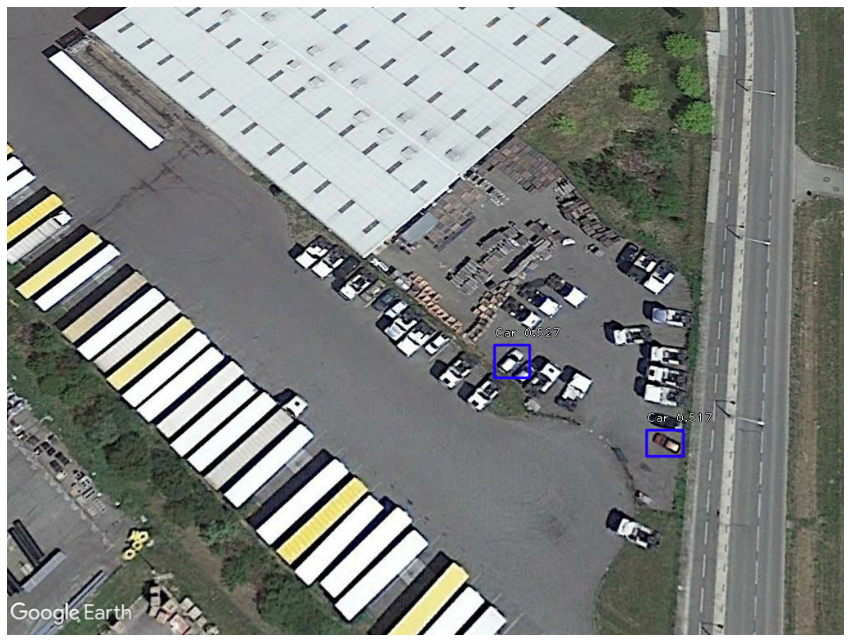

In [15]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
labels_to_names=class_mapping
model_path = os.path.join('m_i.h5')
model_ = models.load_model(model_path, backbone_name='resnet50')
# load image
image = read_image_bgr('/content/keras-retinanet/Dataset/test/images/0035.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model_.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()